# FracAttitude

Jupyter Notebook for geological orientation analysis.

© 2024 Andrea Bistacchi, released under GNU AFFERO V.3 license.

## 1) Data import and reformatting.

In [92]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplstereonet
import sphstat.singlesample
from mpmath.libmp.backend import sage_utils
from sklearn_extra.cluster import KMedoids
import sphstat.singlesample as ss_singlesample
import sphstat.utils as ss_utils

# initialize variables
rad = np.pi/180
deg = 180/np.pi

# change resolution to make figures smaller or larger
plt.rcParams["figure.dpi"] = 400

# import data and preview
# --- MODIFY THIS TO POINT TO YOUR DATA FILE ---
data_lower = pd.read_csv('frac_attitude_data.csv')

# show dataframe
data_lower

,Dip,DipDir_
0,84.790794,47.249985
1,80.846962,39.596832
2,87.935318,38.538193
3,83.888390,211.480164
4,80.757980,222.549362
...,...,...
786,68.656250,135.923401
787,76.161148,122.535019
788,38.897453,135.679932
789,77.396797,118.034248


In [93]:
# rename columns
# --- MODIFY THIS ACCORDING TO YOUR DATA FORMAT ---
data_lower.rename(columns={'DipDir_': 'dipdir', 'Dip': 'dip'}, inplace=True)

# create new polar coords columns
data_lower['plunge'] = 90 - data_lower['dip']
data_lower['trend'] = data_lower['dipdir'] + 180
data_lower['strike'] = (data_lower['dipdir'] - 90)

# reformat as 0-360°, cannot use modulo operator "%" directly due to precedence in arithmetic operations
data_lower['trend'] = data_lower['trend'] % 360
data_lower['strike'] = data_lower['strike'] % 360

# create new cartesian coords columns for pole
data_lower['l'] = np.cos(data_lower['plunge']*rad) * np.cos(data_lower['trend']*rad)
data_lower['m'] = np.cos(data_lower['plunge']*rad) * np.sin(data_lower['trend']*rad)
data_lower['n'] = -np.sin(data_lower['plunge']*rad)

# show dataframe
data_lower

,dip,dipdir,plunge,trend,strike,l,m,n
0,84.790794,47.249985,5.209206,227.249985,317.249985,-0.675997,-0.731289,-0.090793
1,80.846962,39.596832,9.153038,219.596832,309.596832,-0.760737,-0.629266,-0.159072
2,87.935318,38.538193,2.064682,218.538193,308.538193,-0.781685,-0.622632,-0.036028
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605
...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,0.669137,-0.647909,-0.363963
787,76.161148,122.535019,13.838852,302.535019,32.535019,0.522203,-0.818591,-0.239192
788,38.897453,135.679932,51.102547,315.679932,45.679932,0.449250,-0.438712,-0.778271
789,77.396797,118.034248,12.603203,298.034248,28.034248,0.458674,-0.861399,-0.218198


In [94]:
# duplicate data mirroring l,m,n cartesian poles in the upper hemisphere
data_upper = data_lower.copy()
data_upper['l'] = -data_upper['l']
data_upper['m'] = -data_upper['m']
data_upper['n'] = -data_upper['n']

# show dataframe
data_upper

,dip,dipdir,plunge,trend,strike,l,m,n
0,84.790794,47.249985,5.209206,227.249985,317.249985,0.675997,0.731289,0.090793
1,80.846962,39.596832,9.153038,219.596832,309.596832,0.760737,0.629266,0.159072
2,87.935318,38.538193,2.064682,218.538193,308.538193,0.781685,0.622632,0.036028
3,83.888390,211.480164,6.111610,31.480164,121.480164,-0.847974,-0.519235,0.106466
4,80.757980,222.549362,9.242020,42.549362,132.549362,-0.727132,-0.667447,0.160605
...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,-0.669137,0.647909,0.363963
787,76.161148,122.535019,13.838852,302.535019,32.535019,-0.522203,0.818591,0.239192
788,38.897453,135.679932,51.102547,315.679932,45.679932,-0.449250,0.438712,0.778271
789,77.396797,118.034248,12.603203,298.034248,28.034248,-0.458674,0.861399,0.218198


In [95]:
# concatenate data_lower and data_upper
data_both = pd.concat([data_lower, data_upper])

# show dataframe
data_both

,dip,dipdir,plunge,trend,strike,l,m,n
0,84.790794,47.249985,5.209206,227.249985,317.249985,-0.675997,-0.731289,-0.090793
1,80.846962,39.596832,9.153038,219.596832,309.596832,-0.760737,-0.629266,-0.159072
2,87.935318,38.538193,2.064682,218.538193,308.538193,-0.781685,-0.622632,-0.036028
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605
...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,-0.669137,0.647909,0.363963
787,76.161148,122.535019,13.838852,302.535019,32.535019,-0.522203,0.818591,0.239192
788,38.897453,135.679932,51.102547,315.679932,45.679932,-0.449250,0.438712,0.778271
789,77.396797,118.034248,12.603203,298.034248,28.034248,-0.458674,0.861399,0.218198


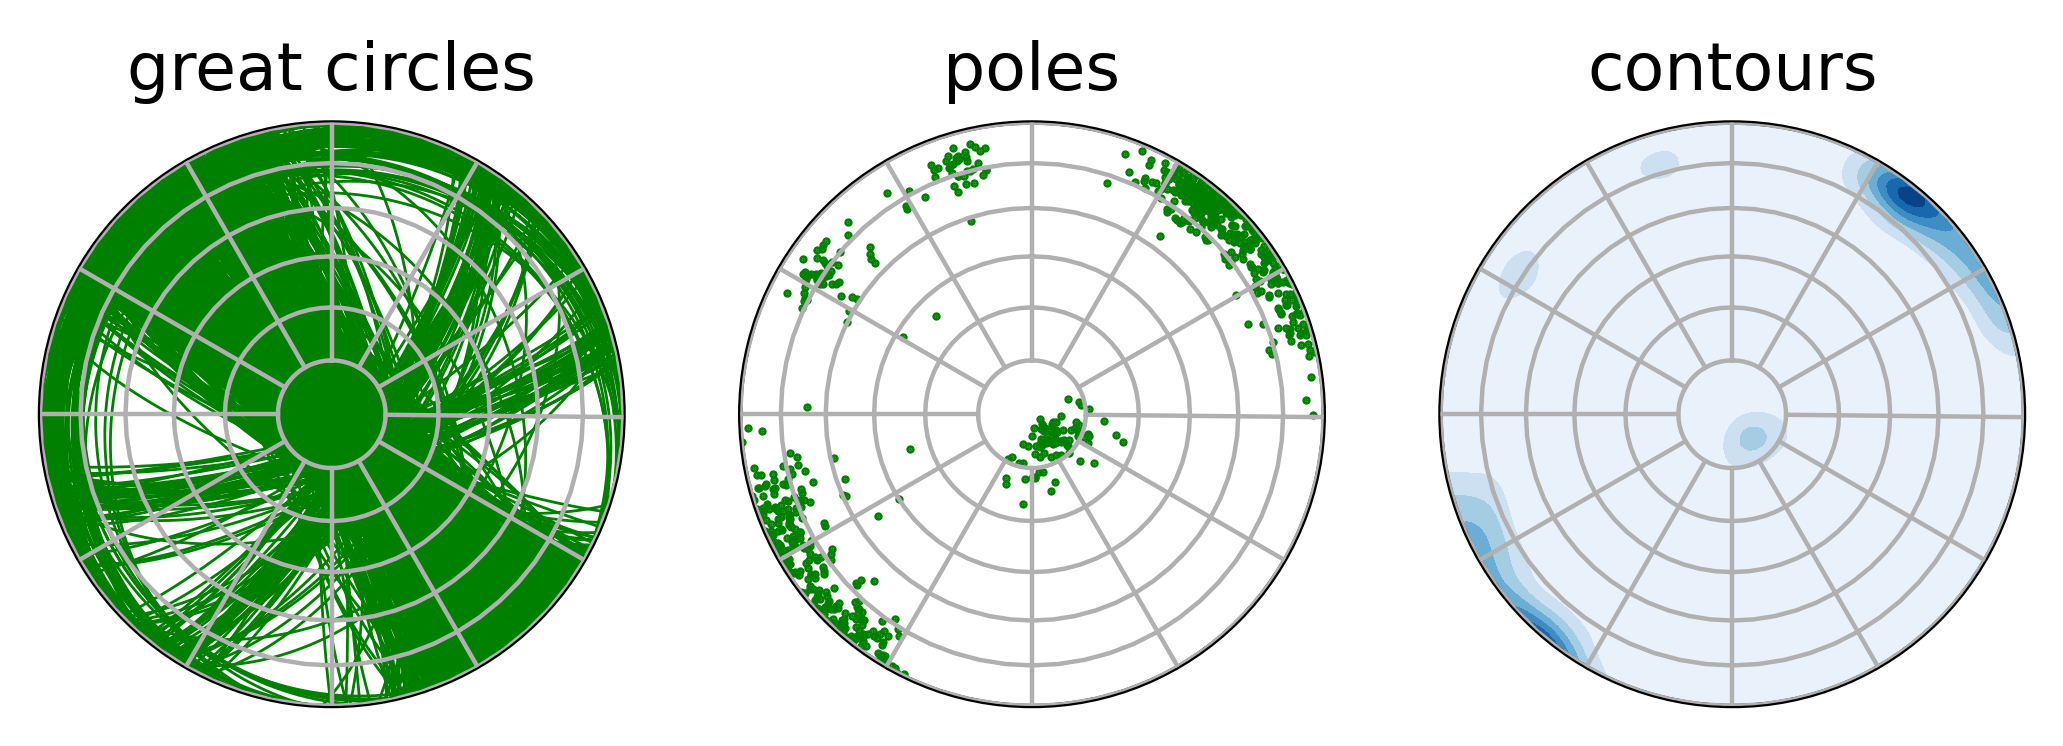

In [96]:
# plot stereonets
fig = plt.figure()

# great circles
ax_1 = fig.add_subplot(131, projection='stereonet')
ax_1.grid(kind="polar")
ax_1.plane(data_lower['strike'] , data_lower['dip'], 'g-', linewidth=.5)
ax_1.set_title('great circles')

# poles
ax_2 = fig.add_subplot(132, projection='stereonet')
ax_2.grid(kind="polar")
ax_2.line(data_lower['plunge'], data_lower['trend'] , 'g.', markersize=1)
ax_2.set_title('poles')

# contours
ax_3 = fig.add_subplot(133, projection='stereonet')
cax = ax_3.density_contourf(data_lower['plunge'], data_lower['trend'] , measurement='lines', cmap='Blues')
ax_3.grid(kind="polar")
ax_3.set_title('contours')

# remove axis labels
for ax in fig.axes:
    ax.tick_params(labelleft = False , labelbottom = False)

## 2) K-medoids clustering.

Specify medoid initialization method with optional init array-like of shape(n_clusters, n_features):
- random selects n_clusters elements from the dataset
- heuristic (default) picks the n_clusters points with the smallest sum distance to every other point
- k-medoids++ follows an approach based on k-means++_, and in general, gives initial medoids which are more separated than those generated by the other methods
- build is a greedy initialization of the medoids used in the original PAM algorithm. Often ‘build’ is more efficient but slower than other initializations on big datasets and it is also very non-robust, if there are outliers in the dataset, use another initialization

Specify medoid method with method:
- alternate (default) is faster
- pam is more accurate

In [97]:
# input number of clusters.
# --- MODIFY THIS ACCORDING TO YOUR DATA ---
n_clusters = 5

# run clustering
kmedoids = KMedoids(n_clusters=n_clusters*2, random_state=0, method='pam', init='k-medoids++').fit(data_both[['l', 'm', 'n']])

# write results in dataframe
data_both['cluster'] = kmedoids.labels_

# show results
print("medoids:\n", kmedoids.cluster_centers_)
print("data_both['cluster'].unique(): ", data_both['cluster'].unique())
data_both

medoids:
 [[-0.12551642  0.09353547 -0.98767239]
 [ 0.42263933  0.90539685  0.04040473]
 [-0.77238551 -0.6324452   0.05859777]
 [ 0.93594339 -0.29471191 -0.19275596]
 [ 0.12551642 -0.09353547  0.98767239]
 [-0.53253948  0.81024747  0.24474627]
 [-0.42263933 -0.90539685 -0.04040473]
 [ 0.53253948 -0.81024747 -0.24474627]
 [ 0.77238551  0.6324452  -0.05859777]
 [-0.93594339  0.29471191  0.19275596]]
data_both['cluster'].unique():  [2 8 1 6 0 7 3 4 5 9]


,dip,dipdir,plunge,trend,strike,l,m,n,cluster
0,84.790794,47.249985,5.209206,227.249985,317.249985,-0.675997,-0.731289,-0.090793,2
1,80.846962,39.596832,9.153038,219.596832,309.596832,-0.760737,-0.629266,-0.159072,2
2,87.935318,38.538193,2.064682,218.538193,308.538193,-0.781685,-0.622632,-0.036028,2
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466,8
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605,8
...,...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,-0.669137,0.647909,0.363963,5
787,76.161148,122.535019,13.838852,302.535019,32.535019,-0.522203,0.818591,0.239192,5
788,38.897453,135.679932,51.102547,315.679932,45.679932,-0.449250,0.438712,0.778271,5
789,77.396797,118.034248,12.603203,298.034248,28.034248,-0.458674,0.861399,0.218198,5


In [98]:
# keep clusters with medoid pointing downwards only
cluster_keep = (kmedoids.cluster_centers_[:,2] <= 0).nonzero()[0]
cluster_keep_centers = kmedoids.cluster_centers_[cluster_keep]
data_keep = data_both.loc[data_both['cluster'].isin(cluster_keep)]

# show results
print("cluster_keep: ", cluster_keep)
print("cluster_keep_centers:\n", cluster_keep_centers)
print("data_keep['cluster'].unique(): ", data_keep['cluster'].unique())
data_keep

cluster_keep:  [0 3 6 7 8]
cluster_keep_centers:
 [[-0.12551642  0.09353547 -0.98767239]
 [ 0.93594339 -0.29471191 -0.19275596]
 [-0.42263933 -0.90539685 -0.04040473]
 [ 0.53253948 -0.81024747 -0.24474627]
 [ 0.77238551  0.6324452  -0.05859777]]
data_keep['cluster'].unique():  [8 6 0 7 3]


,dip,dipdir,plunge,trend,strike,l,m,n,cluster
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466,8
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605,8
7,85.985756,222.469269,4.014244,42.469269,132.469269,0.735830,0.673538,-0.070004,8
9,89.945114,216.183426,0.054886,36.183426,126.183426,0.807131,0.590372,-0.000958,8
13,89.555504,221.108948,0.444496,41.108948,131.108948,0.753438,0.657473,-0.007758,8
...,...,...,...,...,...,...,...,...,...
598,84.594612,249.189407,5.405388,69.189407,159.189407,-0.353700,-0.930603,0.094202,6
604,89.193436,253.327789,0.806564,73.327789,163.327789,-0.286868,-0.957867,0.014077,6
605,87.624664,251.528275,2.375336,71.528275,161.528275,-0.316564,-0.947665,0.041446,6
606,73.788132,256.031799,16.211868,76.031799,166.031799,-0.231785,-0.931842,0.279190,6


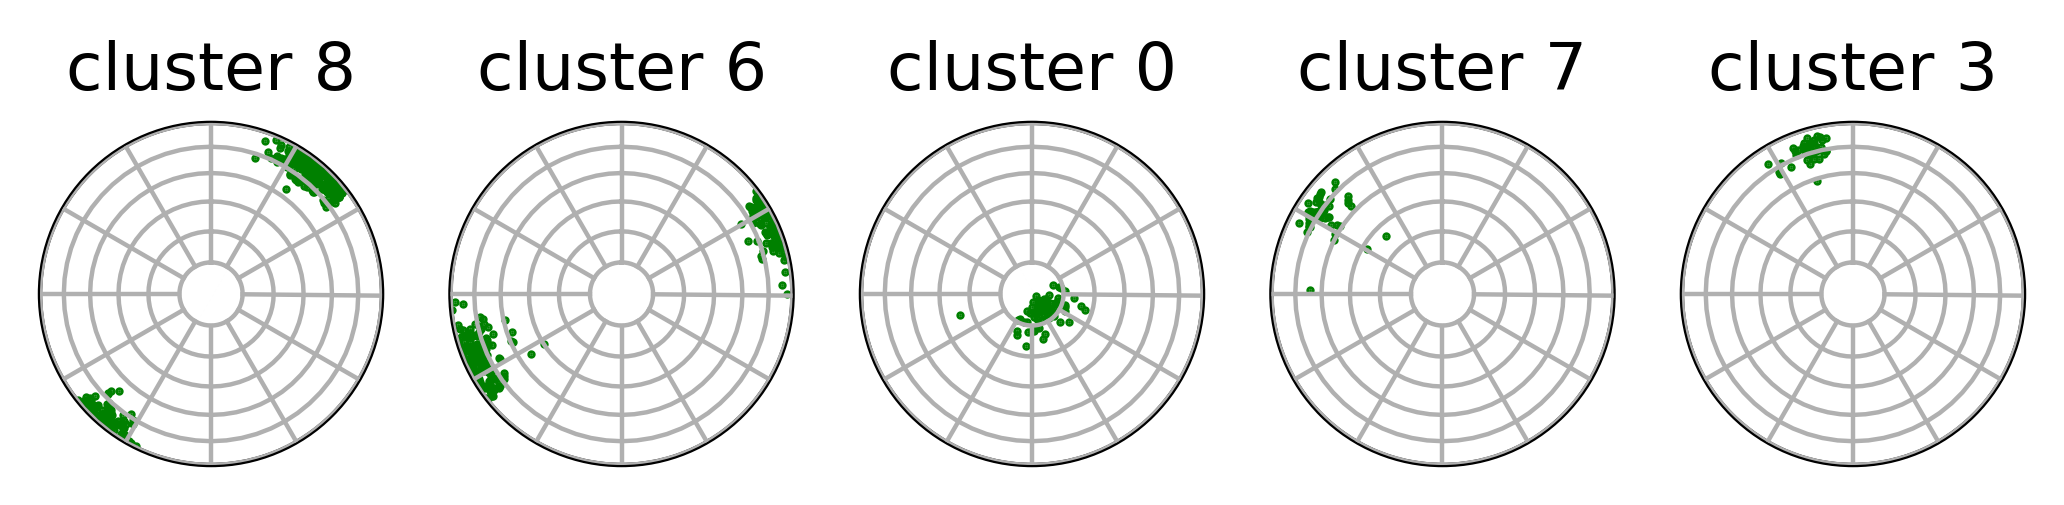

In [99]:
# plot clusters
# create empty figure
fig = plt.figure()

# initialize subplot indexes
n_subplots = 100 + n_clusters*10

# plot for each cluster
for cluster in data_keep['cluster'].unique():
    n_subplots += 1
    plunge = data_keep[data_keep['cluster'] == cluster]['plunge']
    trend = data_keep[data_keep['cluster'] == cluster]['trend']
    ax = fig.add_subplot(n_subplots, projection='stereonet')
    ax.line(plunge, trend, 'g.', markersize=1)
    ax.grid(kind="polar")
    ax.set_title(f"cluster {cluster}")

# remove axis labels
for ax in fig.axes:
    ax.tick_params(labelleft = False , labelbottom = False)

## 3) Descriptive stats and tests for each cluster with [SpheriStat singlesample module](https://sphstat.readthedocs.io/en/latest/sphstat.singlesample.html#).

__fisherparams__ returns a dictionary with keys:
- mdir: Mean direction (theta (colatitude), phi (longitude)) (tuple) (could be converted with ss_utils.poltodi())
- kappa: Concentration parameter (float)
- thetaalpha: Semivertical angle (float)
- cikappa: (kappalow, kappahigh) is the (1-alpha)% CI for kappa (tuple)

__kentparams__ returns:
- axes: Axes of the distribution (axes[0] is the mean direction) (could be converted with ss_utils.cart2sph() and ss_utils.poltodi())
- kappahat: Concentration parameter of the distribution (float)
- betahat: Ovalness parameter (float)

__kentmeanccone__ returns:
- cconept: 360 points on the (1-alpha)% cone of confidence (list)
- ths1: Major semi-axis (in radians)
- ths2: Minor semi-axis (in radians)

__isuniform__ tests if the sample comes from a uniform distribution [True] as opposed to a unimodal distribution [False], returns a dictionary with keys:
- teststat: Test statistic (float)
- crange: Critical range (float)
- testresult: Test result (bool)

__isfisher__ is a goodness-of-fit test of the data with the Fisher model ([True] if the Fisher model is acceptable), returns a dictionary with keys:
- 'colatitute': Results of the colatitude test as a nested dictionary ('stat': Test statistic (float), 'crange': Critical range (float), 'H0': Test result (bool))
- 'longitude': Results of the longitude test as a nested dictionary ('stat': Test statistic (float), 'crange': Critical range (float), 'H0': Test result (bool))
- 'twovariable': Results of the two-variable test as a nested dictionary ('stat': Test statistic (float), 'crange': Critical range (float), 'H0': Test result (bool))
- 'H0': All three tests retain H0 then True, otherwise false
- 'alpha': Type-I error level

__isfishervskent__ tests whether a sample comes from a Fisher distribution [True] against the alternative that it comes from a Kent distribution [False], returns a dictionary with keys:
- K: Test statistic (float)
- cval: Critical value (float)
- p: p-value (float)
- testresult: Test result (bool)

_All angles in the following are shown as degrees._

In [100]:
# set Type-I error level alpha
alpha = 0.05

# clean in case the cell is re-run
try:
    del summary_stats
except:
    pass

# loop for each cluster
for cluster in data_keep['cluster'].unique():
    this_stats = dict()
    this_stats['cluster'] = cluster

    # format data for SpheriStat 'cart' (i.e. cartesian)
    samplecart = dict()
    samplecart['points'] = data_keep.loc[data_keep["cluster"] == cluster, ["l", "m", "n"]].to_numpy()
    samplecart['type'] = 'cart'
    samplecart['n'] = data_keep.loc[data_keep['cluster'] == cluster].shape[0]
    this_stats['n data'] = samplecart['n']

    # estimate parametric distributions

    # Fisher distribution parameters
    fisher_dist = ss_singlesample.fisherparams(samplecart=samplecart, alpha=alpha)
    th, ph = fisher_dist['mdir']
    lat, lon = ss_utils.poltoll(th, ph)
    this_stats['Fisher plunge'] = lat*deg
    this_stats['Fisher trend'] = lon*deg
    this_stats['Fisher dip'] = 90 - lat*deg
    this_stats['Fisher direction'] = (lon*deg + 180) %360
    this_stats['Fisher K'] = fisher_dist['kappa']
    this_stats['Fisher theta_alpha'] = fisher_dist['thetalpha']*deg
    this_stats['Fisher ci_kappa'] = fisher_dist['cikappa']

    # Kent distribution parameters
    axes, kappahat, betahat = ss_singlesample.kentparams(samplecart=samplecart)
    th, ph = ss_utils.cart2sph(axes[0])
    th = th % (np.pi)
    ph = ph % (2*np.pi)
    lat, lon = ss_utils.poltoll(th, ph)
    this_stats['Kent plunge'] = lat*deg
    this_stats['Kent trend'] = lon*deg
    this_stats['Kent dip'] = 90 - lat*deg
    this_stats['Kent direction'] = (lon*deg + 180) %360
    this_stats['Kent K'] = kappahat
    this_stats['Kent beta'] = betahat

    # Kent elliptical confidence cone for the mean direction
    # cconept could be used to plot ellipse on stereoplot, but must be converted to plunge/trend
    cconept, ths1, ths2 = ss_singlesample.kentmeanccone(samplecart=samplecart)
    this_stats['Kent theta s1'] = ths1*deg
    this_stats['Kent theta s2'] = ths2*deg

    # tests

    # Is uniform [True] test:
    uniform_test = ss_singlesample.isuniform(sample=samplecart, alpha=alpha)
    this_stats['Uniform test statistic'] = uniform_test['teststat']
    this_stats['Uniform critical range'] = uniform_test['crange']
    this_stats['Is uniform test'] = uniform_test['testresult']

    # Is Fisher [True] test
    fisher_test = ss_singlesample.isfisher(samplecart=samplecart, alpha=alpha, plotflag=False)
    this_stats['Colatitute test statistic'] = fisher_test['colatitute']['stat']
    this_stats['Colatitute critical range'] = fisher_test['colatitute']['crange']
    this_stats['Is colatitute exponential'] = fisher_test['colatitute']['H0']
    this_stats['Longitude test statistic'] = fisher_test['longitude']['stat']
    this_stats['Longitude critical range'] = fisher_test['longitude']['crange']
    this_stats['Is longitude uniform'] = fisher_test['longitude']['H0']
    this_stats['Two-variable test statistic'] = fisher_test['twovariable']['stat']
    this_stats['Two-variable critical range'] = fisher_test['twovariable']['crange']
    this_stats['Is two-variable normal'] = fisher_test['twovariable']['H0']
    this_stats['Is Fisher test'] = fisher_test['H0']

    # Is Fisher [True] vs. Kent [False] test
    fisher_kent_test = ss_singlesample.isfishervskent(samplecart=samplecart, alpha=alpha)
    this_stats['Fisher vs. Kent test statistic'] = fisher_kent_test['K']
    this_stats['Fisher vs. Kent critical value'] = fisher_kent_test['cval']
    this_stats['Fisher vs. Kent p-value'] = fisher_kent_test['p']
    this_stats['Is Fisher vs. Kent test'] = fisher_kent_test['testresult']

    # add row to dataframe
    try:
        summary_stats = pd.concat([summary_stats, pd.DataFrame.from_dict([this_stats])], ignore_index=False)
    except NameError:
        summary_stats = pd.DataFrame([this_stats])

# show dataframe
summary_stats

C:\Users\bistek\anaconda3\envs\fracattitude\Lib\site-packages\sphstat\singlesample.py:773: RuntimeWarning: invalid value encountered in arcsin
  ths1 = np.arcsin(s1)
C:\Users\bistek\anaconda3\envs\fracattitude\Lib\site-packages\sphstat\singlesample.py:774: RuntimeWarning: invalid value encountered in arcsin
  ths2 = np.arcsin(s2)
C:\Users\bistek\anaconda3\envs\fracattitude\Lib\site-packages\sphstat\singlesample.py:779: RuntimeWarning: invalid value encountered in sqrt
  w0 = np.sqrt(1 - u0**2 - v0**2)


,cluster,n data,Fisher plunge,Fisher trend,Fisher dip,Fisher direction,Fisher K,Fisher theta_alpha,Fisher ci_kappa,Kent plunge,...,Longitude critical range,Is longitude uniform,Two-variable test statistic,Two-variable critical range,Is two-variable normal,Is Fisher test,Fisher vs. Kent test statistic,Fisher vs. Kent critical value,Fisher vs. Kent p-value,Is Fisher vs. Kent test
0,8,351,3.531382,39.997375,86.468618,219.997375,64.7256013668974,0.941094,"(57.95588913833671, 71.47575140579194)",3.531382,...,1.207,True,0.740683,0.895,True,True,5.765119,5.991465,5.599127e-02,True
0,6,256,3.180337,245.236399,86.819663,65.236399,43.3001579678831,1.354363,"(37.99919207331091, 48.5831561601074)",3.180337,...,1.207,False,1.022294,0.895,False,False,16.495107,5.991465,2.618985e-04,False
0,0,86,80.032036,144.348817,9.967964,324.348817,74.2825336176690,1.792813,"(58.644316383251464, 89.82806764927257)",80.032036,...,1.207,False,0.791777,0.895,True,False,35.753112,5.991465,1.723100e-08,False
0,7,56,16.693200,303.746725,73.306800,123.746725,58.6194931483381,2.525799,"(43.3716491145306, 73.75408993749568)",16.693200,...,1.207,False,1.100832,0.895,False,False,5.918977,5.991465,5.184544e-02,True
0,3,42,13.208932,342.378660,76.791068,162.378660,123.094380633489,2.019079,"(86.23144675893634, 159.63772290418518)",13.208932,...,1.207,True,1.339121,0.895,False,False,1.702259,5.991465,4.269325e-01,True
